In [1]:

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
### ALGORITHM TO FIND TCCs ###

import networkx as nx
from itertools import combinations

def find_sep_pairs(G):
    sep_pairs = []
    for sp in list(combinations(G.nodes, 2)): # paralelizable
        H = G.copy()
        H.remove_nodes_from(sp)
        if not nx.is_connected(H):
            sep_pairs.append(sp)
    return sep_pairs


def find_connected_components(G, sep_pairs):
    # Hacer que sea un diccionario con claves cada pareja
    connected_components = {}
    for sep_pair in sep_pairs:
        H = G.copy()
        H.remove_nodes_from(sep_pair)
        
        # Assign labels to nodes based on their connected component
        component_labels = {node: i for i, component in enumerate(nx.connected_components(H)) for node in component}
        connected_components[sep_pair] = component_labels
    return connected_components

    
def find_relation_R(G, connected_components):
    # TODO ESTO SE PUEDE HACER CON UNA MATRIZ TRIANGULAR O SPARSE MEJOR O INCLUSO CON ALGUNA CLASE DE RELACIONES
    relation_R = [[True for _ in range(len(G.nodes))] for _ in range(len(G.nodes))]
    for pair in list(combinations(G.nodes, 2)):
        ## TODO NO HACE FALTA ESTE BOOLEANO
        related = True
        for sep_pair in connected_components.keys():
            if (pair[0] not in sep_pair) and (pair[1] not in sep_pair):
                if connected_components[sep_pair][pair[0]] != connected_components[sep_pair][pair[1]]:
                    # print("sep_pair", sep_pair)
                    # print("pair", pair)
                    related = False
                    #break ## TODO CHECKEAR ESTE BREAK
        relation_R[pair[0]][pair[1]] = related
        relation_R[pair[1]][pair[0]] = related
            
    return relation_R

    
def find_relation_T(G, relation_R):
    relation_T = []
    for trio in list(combinations(G.nodes, 3)):
        if relation_R[trio[0]][trio[1]] and relation_R[trio[0]][trio[2]] and relation_R[trio[2]][trio[1]]:
            relation_T.append(trio)
    return relation_T


def find_triply_connected_from_T_R(G, rel_T, rel_R):
    triply_components = []
    for rel_T_elem in rel_T:
        triply_component = list(rel_T_elem)#.copy()
        for node in G.nodes:
            if rel_R[rel_T_elem[0]][node] and rel_R[rel_T_elem[1]][node] and rel_R[rel_T_elem[2]][node]:
                triply_component.append(node)
        triply_components.append(triply_component)
    # delete repeated elements
    return list(set(frozenset(comp) for comp in triply_components))
    #return list(set(tuple(comp) for comp in triply_components))
    # return list(set(triply_components))
    

def find_triply_connected_comps(G):
    sep_pairs = find_sep_pairs(G)
    connected_components = find_connected_components(G, sep_pairs) 
    relation_R = find_relation_R(G, connected_components)
    relation_T = find_relation_T(G, relation_R)
    TCC = find_triply_connected_from_T_R(G, relation_T, relation_R)
    return TCC, relation_T, relation_R, connected_components, sep_pairs

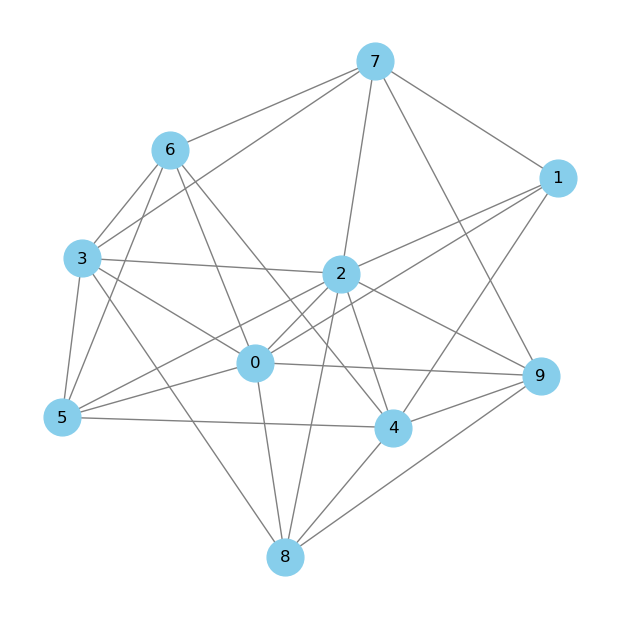

True
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [3]:
### CREATE A RANDOM GRAPH G ###

import networkx as nx
import matplotlib.pyplot as plt

# Parameters
n = 10 # Number of nodes
p = 0.5  # Probability of edge creation

# Generate a random connected Erdős-Rényi graph
G = nx.erdos_renyi_graph(n, p)
# while not nx.is_connected(G):
#     G = nx.erdos_renyi_graph(n, p)

# Draw the graph
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
plt.show()
print(nx.is_connected(G))

# Assign labels to nodes based on their connected component
component_labels = {node: i for i, component in enumerate(nx.connected_components(G)) for node in component}

# Print node labels
print(component_labels)

In [4]:
TCC, _, _, _, _ = find_triply_connected_comps(G)
print(TCC)

[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9})]


C:\Users\carlo\AppData\Local\Temp\ipykernel_16648\4275796216.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("tab10", num_components)  # Use tab10 colormap


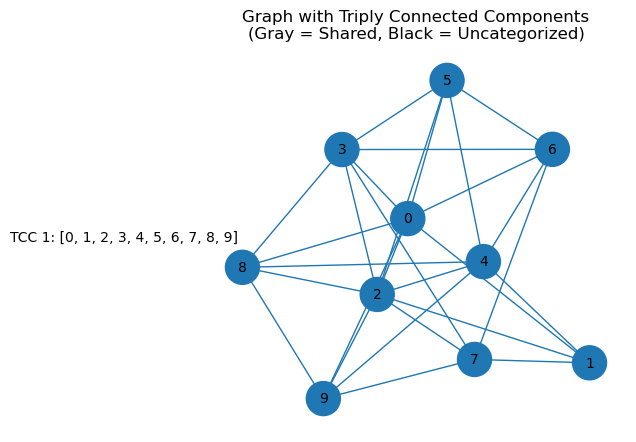

In [5]:
### PRINT TRIPLY CONNECTED COMPONENTS ###

import networkx as nx
import matplotlib.pyplot as plt
import textwrap  # For wrapping long lines

def print_triply_connected_components(G, TCC, max_line_length=40):
    # Initialize classification dictionaries
    node_classes = {}  # Store which TCC each node belongs to
    edge_classes = {}  # Store which TCC each edge belongs to
    
    # Assign nodes and edges to their TCCs
    for class_idx, component in enumerate(TCC):
        for node in component:
            node_classes.setdefault(node, []).append(class_idx)
        
        for edge in G.edges():
            if edge[0] in component and edge[1] in component:
                edge_classes.setdefault(edge, []).append(class_idx)
    
    # Define colors:
    num_components = len(TCC)
    color_map = plt.cm.get_cmap("tab10", num_components)  # Use tab10 colormap

    node_colors = []
    for node in G.nodes():
        if node not in node_classes:  
            node_colors.append("black")  # Uncategorized node
        elif len(node_classes[node]) > 1:  
            node_colors.append("gray")  # Shared node
        else:  
            node_colors.append(color_map(node_classes[node][0]))  

    edge_colors = []
    for edge in G.edges():
        if edge not in edge_classes:  
            edge_colors.append("black")  
        elif len(edge_classes[edge]) > 1:  
            edge_colors.append("gray")  
        else:  
            edge_colors.append(color_map(edge_classes[edge][0]))  

    # Create figure and adjust layout
    fig, ax = plt.subplots(figsize=(7, 5))
    pos = nx.spring_layout(G, seed=42)  
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, 
            node_size=600, edge_cmap=color_map, font_size=10, ax=ax)

    # Add title
    plt.title("Graph with Triply Connected Components\n(Gray = Shared, Black = Uncategorized)")

    # Adjust margins to make space for the text (left margin for separation)
    plt.subplots_adjust(left=0.3)  # Increase left margin to create space

    # Format the TCC list with line wrapping
    formatted_tcc_list = []
    for i, comp in enumerate(TCC):
        comp_str = f"TCC {i+1}: {sorted(list(comp))}"
        wrapped_lines = textwrap.wrap(comp_str, width=max_line_length)
        formatted_tcc_list.extend(wrapped_lines)

    # Move the text to the left and ensure proper spacing
    subtitle_text = "\n".join(formatted_tcc_list)
    plt.figtext(0.02, 0.5, subtitle_text, wrap=True, horizontalalignment='left', 
                verticalalignment='center', fontsize=10)

    plt.show()

# Compute triply connected components
TCC, relation_T, relation_R, connected_components, sep_pairs = find_triply_connected_comps(G)

# Print the graph with TCC classifications
print_triply_connected_components(G, TCC)


In [6]:
### MAKE GRAPH EXAMPLES ###

import networkx as nx

graph_examples = []

## G1 ##

# Graph 1: K4 (Complete graph on 4 vertices) - 1 triply connected component
G1 = nx.complete_graph(4)
graph_examples.append(G1)

## G2 ##

# Graph 2: K5 (Complete graph on 5 vertices) - 1 triply connected component
G2 = nx.complete_graph(5)
graph_examples.append(G2)

## G3 ##

# Graph 3: Two K4s joined by a bridge (2 triply connected components)
G3 = nx.Graph()
G3.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)])  # K4-1
G3.add_edges_from([(4, 5), (5, 6), (6, 7), (7, 4), (4, 6), (5, 7)])  # K4-2
G3.add_edge(2, 4)  # Single edge bridge
graph_examples.append(G3)

## G4 ##

# Graph 4: K4 with an extra node connected to all (1 triply connected component)
G4 = nx.complete_graph(4)
G4.add_node(4)
G4.add_edges_from([(4, 0), (4, 1), (4, 2), (4, 3)])
graph_examples.append(G4)

## G5 ##

# Graph 5: A ladder-like graph with extra cross edges (3 triply connected components)
G5 = nx.Graph()
edges5 = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Chain
          (6, 7), (7, 8), (8, 9), (9, 10), (10, 11),  # Parallel Chain
          (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11),  # Vertical connections
          (1, 6), (2, 7), (3, 8), (4, 9), (5, 10)]  # Cross connections
G5.add_edges_from(edges5)
graph_examples.append(G5)

## G6 ##

# Graph 6: A cube graph (4 triply connected components)
G6 = nx.cubical_graph()  # A cube where opposite vertices connect
graph_examples.append(G6)

## G7 ##

# Graph 7: Two K4s joined at two vertices (3 triply connected components)
G7 = nx.Graph()
G7.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)])  # K4-1
G7.add_edges_from([(2, 4), (4, 5), (5, 6), (6, 2), (4, 6), (5, 2)])  # K4-2
graph_examples.append(G7)

## G8 ##

# Graph 8: A triangular mesh with increasing connectivity (5 triply connected components)
G8 = nx.Graph()
edges8 = [(0, 1), (1, 2), (2, 3), (3, 0),  # Outer cycle
          (0, 4), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (3, 7), (0, 7),  # Inner connections
          (4, 5), (5, 6), (6, 7), (7, 4)]  # Inner cycle
G8.add_edges_from(edges8)
graph_examples.append(G8)

## G9 ##

# Create a new graph similar to the image
G9 = nx.Graph()

# Add nodes
G9.add_nodes_from(range(12))  # Arbitrary node numbers

# Add inner highly connected structure (approximating the central dense part)
inner_edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # K4-like core
    (0, 4), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (3, 7), (0, 7),  # Inner connections
    (4, 5), (5, 6), (6, 7), (7, 4)  # Inner cycle
]

# Add outer edges extending from the central structure
outer_edges = [
    (1, 8), (4, 8), (2, 9), (5, 9), (3, 10), (6, 10), (7, 11), (0, 11),
    (8, 9), (9, 10), (10, 11), (11, 8)  # Outer cycle
]

# Large external loop (approximating the curve in the image)
loop_edges = [(8, 12), (12, 9), (12, 10), (12, 11)]  # Adding a large external node

# Add all edges
G9.add_edges_from(inner_edges + outer_edges + loop_edges)

# Add to graph examples
graph_examples.append(G9)


### GRAPHS IN THE PAPER ###

## G10 ##

# Create the graph
G10_new = nx.Graph()

# Add central nodes
central_nodes = [0, 1, 2, 3]
G10_new.add_nodes_from(central_nodes)

# Define additional nodes for K4s (shifted by -1)
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
extra_nodes = {pair: (i, i + 1) for i, pair in zip(range(4, 16, 2), pairs)}

# Add edges for each K4 structure
for (a, b), (x, y) in extra_nodes.items():
    G10_new.add_edges_from([(a, b), (a, x), (a, y), (b, x), (b, y), (x, y)])

# Add to graph examples
graph_examples.append(G10_new)

## G11 ##

# Create the graph
G11 = G10_new.copy()
G11.add_nodes_from([14, 15])
G11.add_edges_from([(1, 3), (3, 14), (1, 14), (1, 15), (15, 14)])    

# Add to graph examples
graph_examples.append(G11)



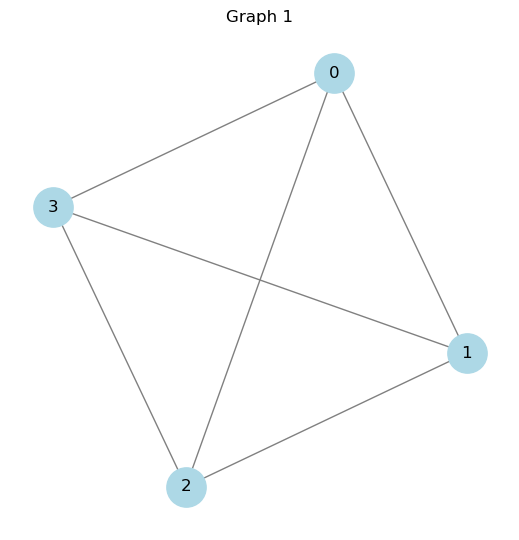

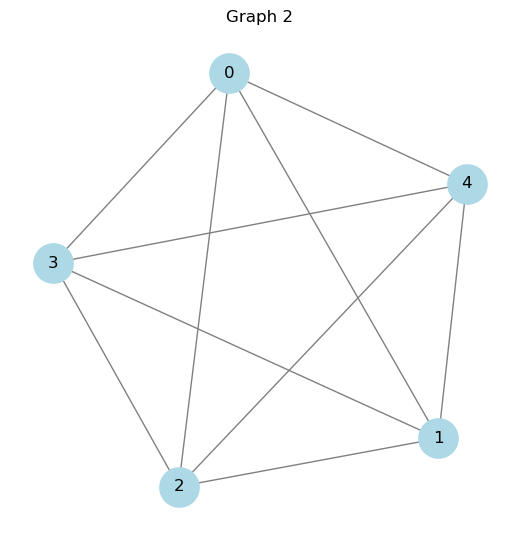

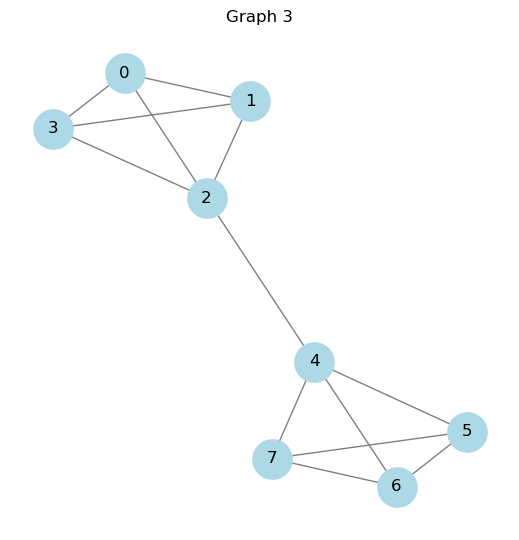

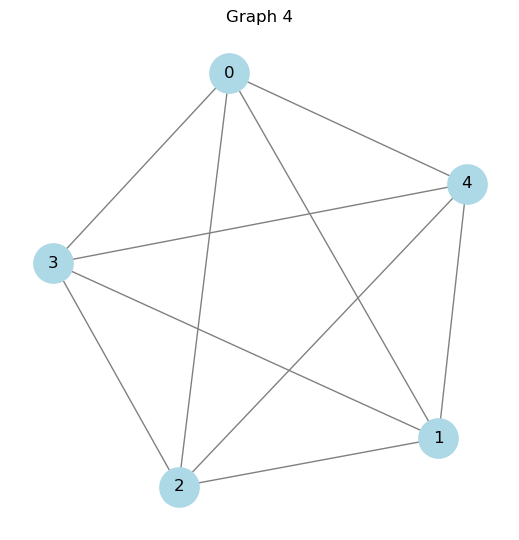

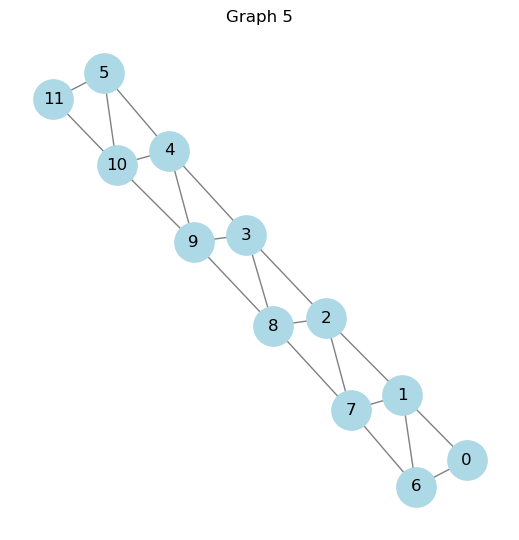

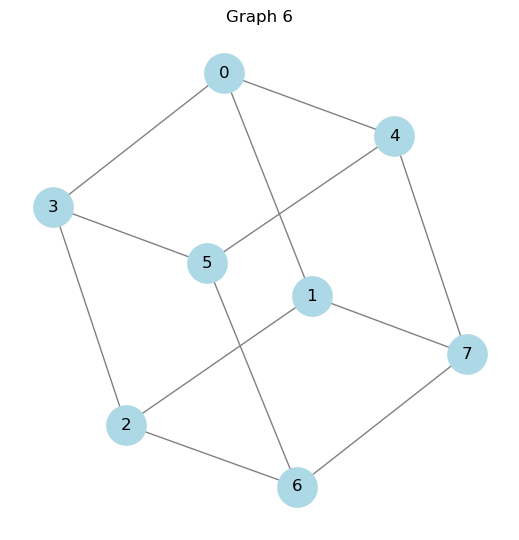

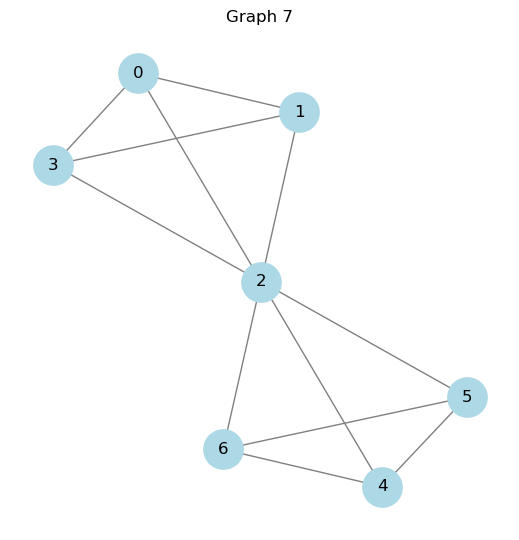

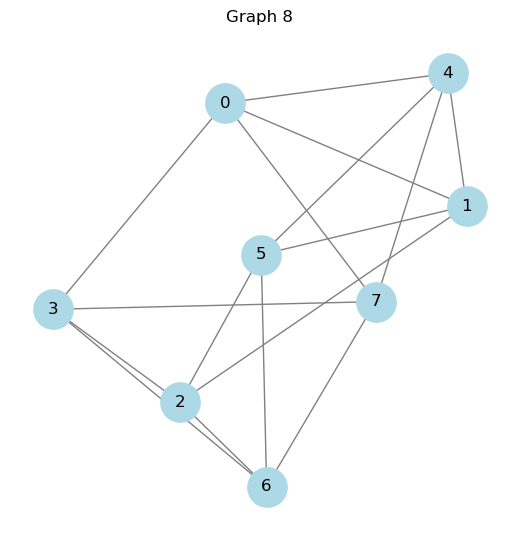

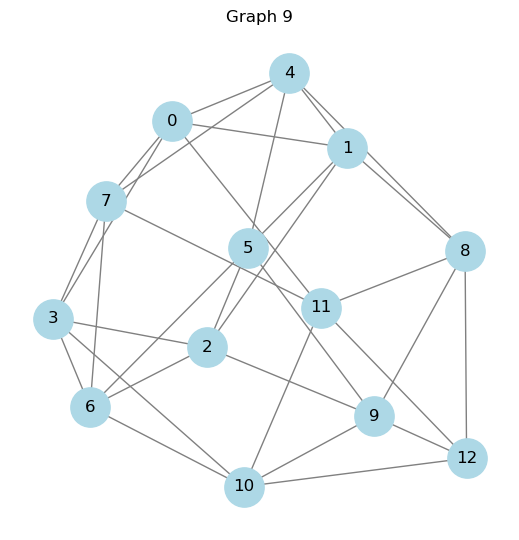

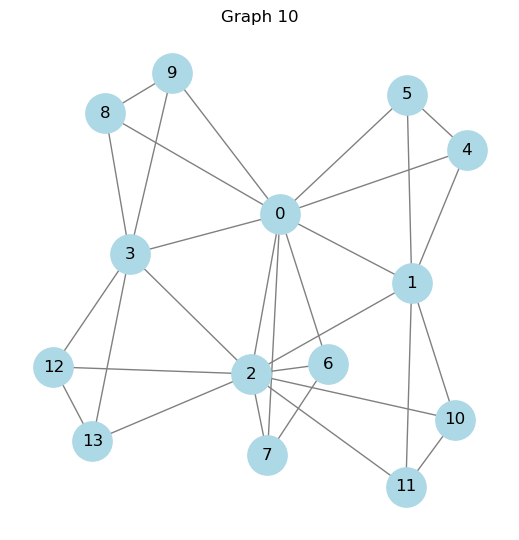

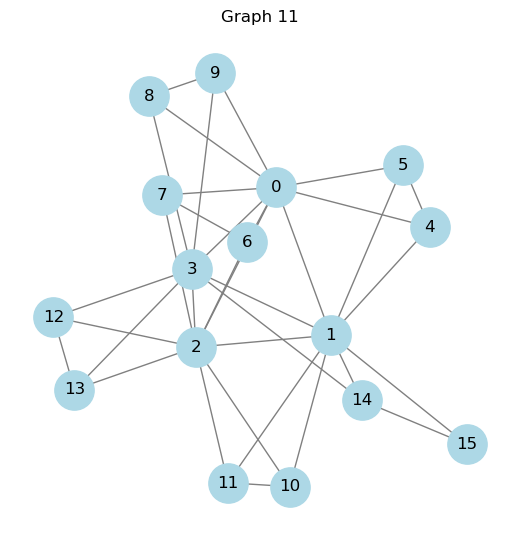

In [7]:
import matplotlib.pyplot as plt

def draw_graph(G, title):
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G, seed=42)  # Positions for nodes
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=800, font_size=12)
    plt.title(title)
    plt.show()

# Iterate over the graphs and draw them
for i, G in enumerate(graph_examples):
    draw_graph(G, f"Graph {i+1}")


C:\Users\carlo\AppData\Local\Temp\ipykernel_16648\4275796216.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("tab10", num_components)  # Use tab10 colormap


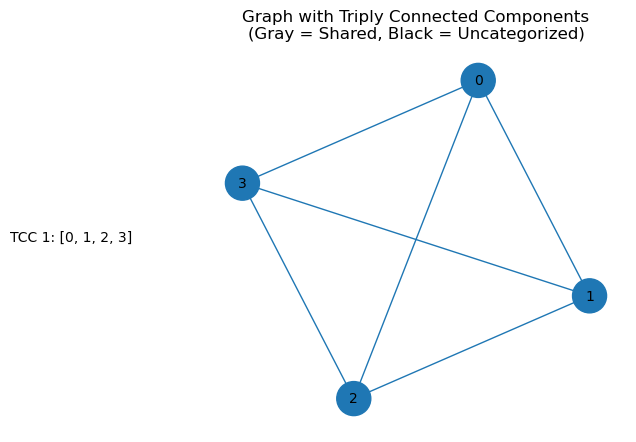

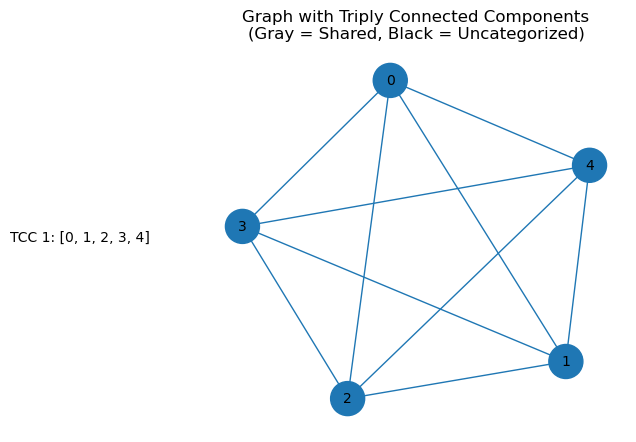

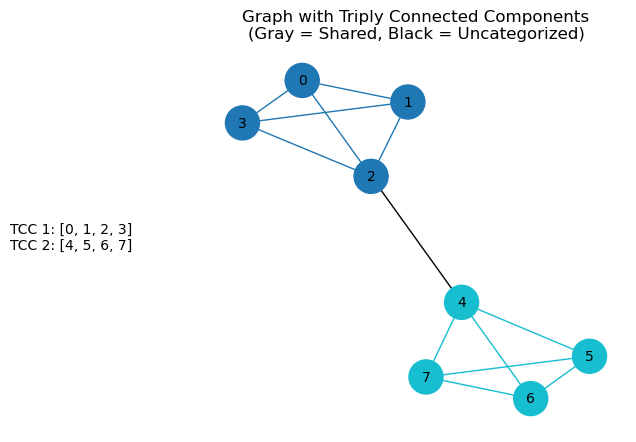

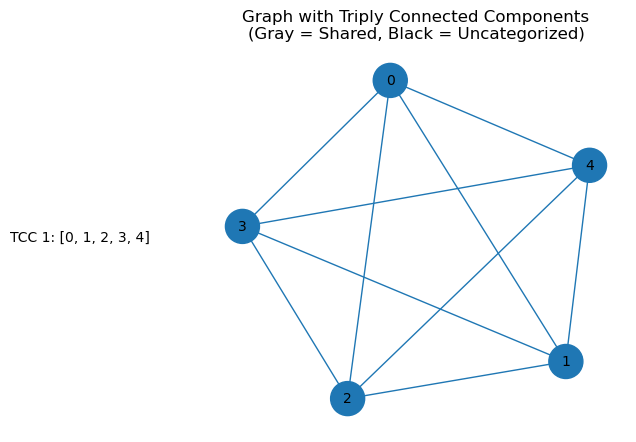

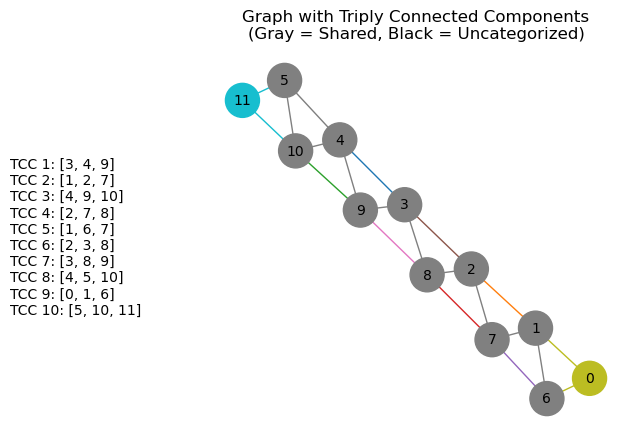

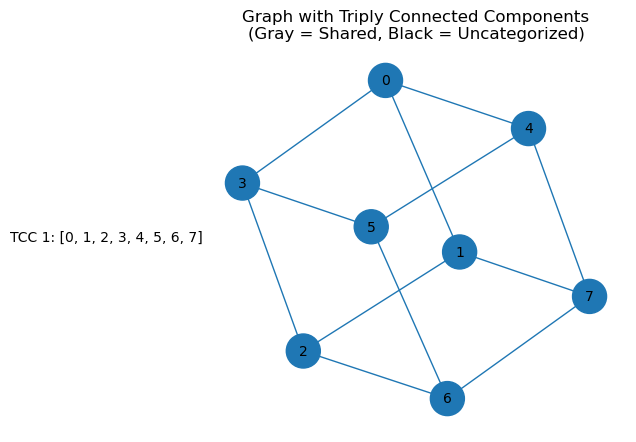

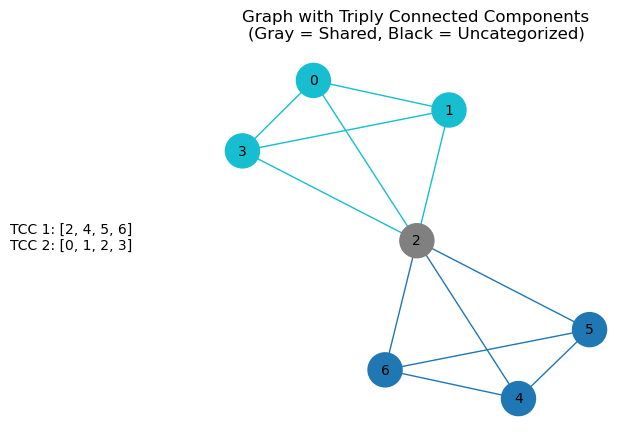

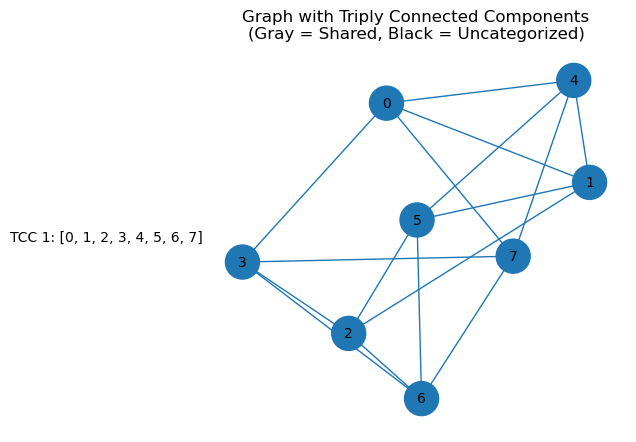

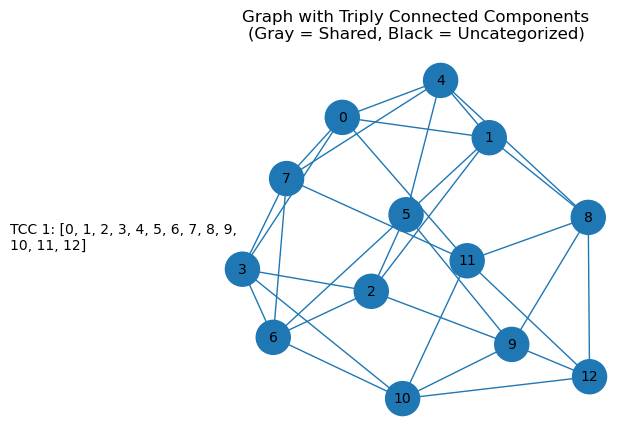

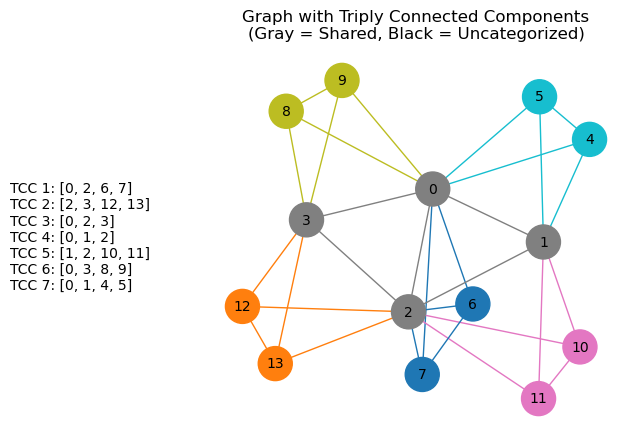

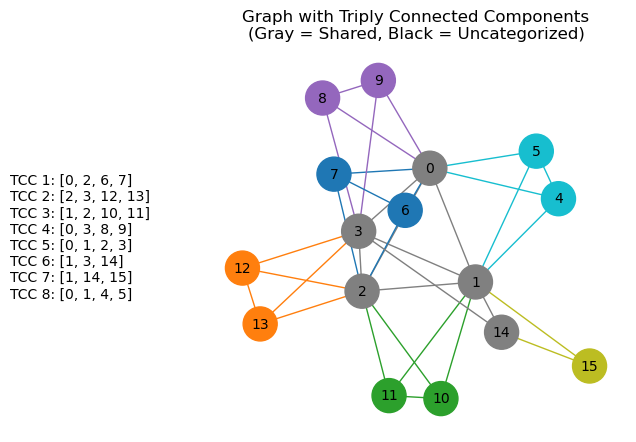

In [8]:
all_TCCs = [find_triply_connected_comps(G)[0] for G in graph_examples]

for graph_ex, TCC_ex in zip(graph_examples, all_TCCs):
    print_triply_connected_components(graph_ex, TCC_ex)